# Local Optimization

For this project, I chose to use the Gradient Descent Method, the Conjugate Descent Method, and the Quasi-Newton Method for optimization.

The goal of this project was to implement these algorithms with the Rosebrock function. The Rosenbrock function is a non-convex function that serves as a testing problem for optimization algorithms (Wikipedia). So essentially, this two variable function will have multiple minimum and values that can serve as minimums.

The function looks like this

$$f(x,y)=a(1-x)^2 + b(y-x^2)^2$$

For the variables of a and b, they determine the final shape of the Rosenbrock graph, but the purposes of this assignment I chose the variables to be a=1 and b=100 respectively. This selection ensures that the global minimum will happend at 

$$(x, y) = (1, 1)$$

where

$$z=0$$

### Setting up the constants

In this sections I will be setting up the constants, that will be used throughout the rest of the program

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import copy
import sys

#this is the function, a=1, b=100
f = lambda x0: (1-x0[0])**2 + 100*(x0[1] - x0[0]**2)**2

#This will generate a random x in the range of [-2, 2]
#xr = [(4*random.random() - 2), (4*random.random() - 2)] -- This was the testing rang

#This rang is for presentation purposes, it ensures that the graphs will not have to draw too much outside 
#the bounds of the countour
xr = [(2*random.random() - 1), (2*random.random() - 1)]
print(xr)

#This will save this random number so that it can be used between 
#optimization algorithms
#-- The deepcopy doesn't use the dynamic links that interpreters use,
#-- so a new memory slot is create for this variable
copyX = copy.deepcopy(xr)

[-0.016952843701211417, -0.9567365027220323]


## Gradient Descent

This is the first algorithm that I implemented in this project because it is usually the easiest to implement. The way this algorithm works is that it follows the path of steepest descent of the gradient of the function.

The algorithm in two dimensions looks like this

$$ x_{n+1} = x_{n} - \gamma \nabla f(x) $$

where x is a vector of the coordinates, and $\gamma$=0.0005

These next iterated coordinates are found with the following derivative equations:

$$ x_{n+1}=\frac {f(x+\frac {d}{2}, y)-f(x-\frac {d}{2}, y)}{d} $$
$$ y_{n+1}=\frac {f(x, y+\frac {d}{2})-f(x, y-\frac {d}{2})}{d} $$

The numerator is the difference between two half differential steps. This essentially creates an averate over the differential step at that point


In [25]:
#Define the derivate function
def derivative(f, x0, y0, d=0.00001):
    x, y = x0, y0
    fx = (f(x+d/2, y)-f(x-d/2, y))/d
    fy = (f(x, y+d/2)-f(x, y-d/2))/d
    return fx, fy

#Gradient Descent fixed size
def gradientDescentFixed(f, xy, N=10000):
    
    x_now = xy[0]
    y_now = xy[1]
    conv = False
    x_hist = []
    x_hist.append([x_now, y_now])
    
    for _ in range(N):
        df_x, df_y = derivative(f, x_now, y_now)
        x_next = x_now - df_x*0.0005
        y_next = y_now - df_y*0.0005
        
        if f(x_next, y_next) > f(x_now, y_now):
            converged = True
            break
        else:
            x_now, y_now = x_next, y_next
            x_hist.append([x_now, y_now])
            
    return conv, np.array(x_hist), f(x_now, y_now)

In [26]:
z = lambda x, y: (1 - x)**2 + (100*((y - x**2)**2))
#This is the test bed
xy = copy.deepcopy(copyX)

c, h, m = gradientDescentFixed(z, xy)

In [27]:
print(m)

0.0019368360280609819


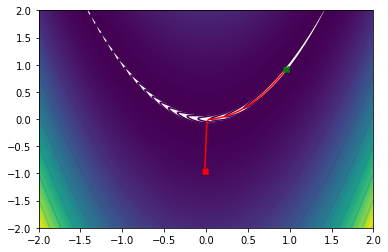

In [28]:
#Here is the contour graph of the function
nx = np.linspace(-2, 2, 400)
ny = np.linspace(-2, 2, 400)

#This is the meshgrid
xm, ym = np.meshgrid(nx, ny)
zm = f([xm, ym])

#This will set the plot
fig = plt.figure()
levels = np.arange(np.min(zm), np.max(zm), 0.3)
plt.contour(xm, ym, zm, levels=levels)
plt.contour(xm, ym, zm)

#This will grab the points from the history
x0 = []
y0 = []
for i in h:
    x0.append(i[0])
    y0.append(i[1])
    
#This is the plot
plt.plot(x0, y0, "r-")
plt.plot(h[0][0], h[0][1], "rX")
plt.plot(h[-1][0], h[-1][1], "gX")

plt.show()

The thing about this algorithm is that by setting $\gamma$=0.0005 and the differential step to df=0.00001, we will ultimately be finding an answer close to the global minimum. Anything less then these values will just result in one iteration because many of the points less then 2 and greater then -2 are in a basin already. To find the true global minimum, I would need to let N be larger then 10000

## Conjugate Gradient Descent

This is the second method I implemented for this project. The conjugate gradient descent method is suppose to be a more efficient implementation of the gradient descent method or steepest descent method.

In algorithms like the steepest descent method, basis vectors are orthogonal to the current path, and this can actually lead to a loss in progress between each descent path.

The Conjugate descent method gets rid of this problem by having each descent vector being orthogonal to the previous one, there is no relation to the current point on the graph, instead only on the previous path taken. This ensures that all progress is preserved, and makes getting to the end of the graph much quicker. 

Generally, the number of iterations done by this algorithm is in relation to the degree value of the basis function. Which usually not many iterations. 

The best way to represent the conjugate descent method is with the Quadratic Matrix form of a multivariable function, which looks something like this:

$$f(x, y) = \frac {1}{2}x^T[A]x + b^Tx + c$$

Where A is the Hessian matrix of the of the function. The Hessian matrix is a positive definite, symmetric matrix, that is obtained by taking the second gradient of the function.

$$ \nabla^2f(x, y) = \left[\begin{array}{cc} \frac {\partial^2f}{\partial x^2} & \frac {\partial^2f}{\partial y\partial x} \\ \frac {\partial^2f}{\partial x\partial y} & \frac {\partial^2 f}{\partial y^2} \\ \end{array}\right] $$

The b vector is also predetermined by the original function. 

The solution for the conjugate descent method is found by taking the first derivative of the function, and is given by the following equation:

$$ 0 = b - [A]x $$

What this equation says is that the first derivative of the quadratic matrix function must equal zero for this a stationary point to have been found. In our case we know it will be a minimum, but in general, it will find a stationary point

In [29]:
#We will establish the hessian here, because this function has
#constants a and b, it will easier to just establish it before using it
#|2-400y+1200x**2     -400x|
#|                         |
#|-400x                 200|

#Restablish the starting x
x = copy.deepcopy(copyX)

j = 2 - (400 * x[1]) + (1200*(x[0]**2))
k = -400 * x[0] 
l = -400 * x[0]
m = 200

H = np.array([[j, k], [l, m]])
print("Hessian -> " + str(H) + "\n")

#The vector b was found previous by solving the quadtratic matrix
#as is, and then finding the missing constants. 
#|-2-500x**3|
#|          |
#|400x**2   |


c = -2-500*(x[0]**3)
e = 400*(x[0]**2)

b = np.array([c, e])
print("b --> " + str(b))

Hessian -> [[385.03947978   6.78113748]
 [  6.78113748 200.        ]]

b --> [-1.99756389  0.11495956]


### The algorithm

The way this iterative algorithm works is a little different from the other two in this presentation. Instead of generating a new point for each new iteration, this algorithm with generate a new orthogonal basis vector for each step.

These basis vectors are generated from the the residuals (r) of each iteration, and the basis vectors (p) of each step. The residuals are just the errors that is generated from the initial difference between b and the product Ax when they don't equal each other. 

Each iteration will generate an $\alpha$ constant, which is the ratio of the square magnitude of the current residual, and the product of the basis vector and the Hessian. 

$$\alpha_{k} = \frac {(r^Tr)}{(p_{k}^r[A]p_{k})}$$

This $\alpha$ constant is is used to find the next coordinates, or the coordinates that is associated with the new basis vector. This same alpha constant will also be used to find the next residual. Again, with each step, this residual should get smaller, as the ratio of the error becomes smaller. 

$$x_{k+1} = x_{k} + \alpha_{k}*p_{k}$$
$$r_{k+1} = r_{k} - {\alpha_{k}*[A]*p_{k}}$$
$$\beta_{k} = \frac {r_{k+1}^Tr_{k+2}}{r_{k}^Tr_{k}}$$

The new basis vector is calculated from a $\beta$ constants that is the ratio of magnitude of the new and previous residuals squared.

$$p_{k+1} = r_{k+1} + \beta_{k}*p_{k}$$

This process is repeated until the residual is as close to 0 as possible. 

In [30]:
#Define the residual and the starting basis function
r0 = b - np.matmul(H, x)
p0 = r0
q = 1

h = [x]

#This is where the algorithm starts
for _ in range(2):
    alpha = (r0[0]**2 + r0[1]**2)/np.matmul(np.matmul(p0, H), p0)
    nextX = x + alpha*p0
    nextR = r0 - (alpha*np.matmul(H, p0))
    beta = (nextR[0]**2 + nextR[1]**2)/(r0[0]**2+r0[1]**2)
    nextP = nextR + beta*p0
    
    #Reassign stuff
    p0=nextP
    r0=nextR
    x=nextX
    h.append(nextX)
    
    if np.sqrt(r0[0]**2+r0[1]**2) < 1e-40:
        break
    
    q += 1
    sys.stdout.write("\rIterations %d" %q)
    sys.stdout.flush()
    
    
print()

Iterations 3


In [31]:
print(x)

[-0.00520117  0.00075115]


In [32]:
#The proof that this is a minimum is if when this x is multiplied to the 
#hessian, that vector will equal the b vector
print("b --> " + str(b))
print("Ax --> " + str(np.matmul(H, x)))

b --> [-1.99756389  0.11495956]
Ax --> [-1.99756389  0.11495956]


In [33]:
#This is the local minimum from the starting point

print("Optimization --> " + str(f(x)))

Optimization --> 1.0104818325438067


In [34]:
#This will be the comparison to scipy miminize

res = minimize(f, copyX, method='CG', tol=1e-40, options={'disp': True})

         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 186
         Gradient evaluations: 58


-0.016952843701211417 -0.9567365027220323
-0.005201174485487334 0.0007511472153457141


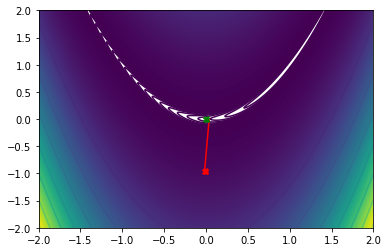

In [35]:
nx = np.linspace(-2, 2, 400)
ny = np.linspace(-2, 2, 400)

#This is the meshgrid
xm, ym = np.meshgrid(nx, ny)
zm = f([xm, ym])

#This will set the plot
fig = plt.figure()
levels = np.arange(np.min(zm), np.max(zm), 0.3)
plt.contour(xm, ym, zm, levels=levels)
plt.contour(xm, ym, zm)

#This will grab the points from the history
x0 = []
y0 = []

for i in h:
    x0.append(i[0])
    y0.append(i[1])
    
#This is the plot
plt.plot(x0, y0, "r-")
plt.plot(h[0][0], h[0][1], "rX")
plt.plot(h[-1][0], h[-1][1], "gX")

plt.show()

## Quasi-Newton Method

This is the third method I used is the quasi-netwon method. A BFGS optimization algorithm that uses the product of the inverse hessian matrix and the first gradient of a function to iteritavely descent throught the function from a random starting point. The equation for this function looks something like this:

$$ x_{k+1} = x_{k} - [H^{-1}]_{k}* \nabla{f(x_{k})} $$

This algorithm stops when the gradient is equal to zero. This, like the conjugate descent method, indicates a stationary point along the first derivative of the function. In our case, we know this is a minimum, but again, I will just specify it as a stationary point. 

A note, in a normal quasi-Newton optimization, you don't need to recalculate the hessian with each iteration, but in this case you do, because the Hessian isn't a constant hessian, so with each itertation, the gradient and hessian change to the value of the newly found x. 

In [36]:
#This is the same hessian as earlier, there will just be added steps to
#create the inverse hessian matrix
#Restablish the starting x
x = copy.deepcopy(copyX)
print(x)
j = 2 - (400 * x[1]) + (1200*(x[0]**2))
k = -400 * x[0] 
l = -400 * x[0]
m = 200

#These variabls will be used in calculating the inverse
dM = copy.deepcopy(m)
dK = copy.deepcopy(k)
dL = copy.deepcopy(l)
dJ = copy.deepcopy(j)

m *= (1/((dJ*dM) - (dK*dL)))
k *= (-1/((dJ*dM) - (dK*dL)))
l *= (-1/((dJ*dM) - (dK*dL)))
j *= (1/((dJ*dM) - (dK*dL)))

#This is the final inverse hessian
H = np.array([[j, k], [l, m]])
print("Hessian -> " + str(H) + "\n")

[-0.016952843701211417, -0.9567365027220323]
Hessian -> [[ 5.00298744e-03 -8.81103041e-05]
 [-8.81103041e-05  2.59868803e-03]]



In [37]:
#This is the gradient of the function
#|-2a+2x-4byx+4x**3b|
#|                  |
#|2by-2x**2         |
grad = np.array([-2+(2*x[0])-(4*100*x[1]*x[0])+(4*100*x[0]**3), (2*100*x[1])-(2*x[0]**2)])
print(grad)

[  -8.52361634 -191.34787534]


In [38]:
#The algorithm begins here
q = 0
h = [np.array(x)]
while grad[0]**2 + grad[1]**2 > 1e-5:
    nextX = x - np.matmul(H, grad)

    #Reassign the new matrix
    j = 2 - (400 * nextX[1]) + (1200*(nextX[0]**2))
    k = 400 * nextX[0] 
    l = 400 * nextX[0]
    m = 200
    
    #This deep copy will remake the array
    dM = copy.deepcopy(m)
    dK = copy.deepcopy(k)
    dL = copy.deepcopy(l)
    dJ = copy.deepcopy(j)

    m *= (1/((dJ*dM) - (dK*dL)))
    k *= (1/((dJ*dM) - (dK*dL)))
    l *= (1/((dJ*dM) - (dK*dL)))
    j *= (1/((dJ*dM) - (dK*dL)))
    
    H = np.array([[m, k], [l, j]])
    
    #Reassigning the gradient
    grad = np.array([-2+(2*nextX[0])-(4*100*nextX[1]*nextX[0])+(4*100*nextX[0]**3), (2*100*nextX[1])-(2*nextX[0]**2)])
    
    #Reassigning the x
    x = nextX

    q+=1
    sys.stdout.write("\r Iterations %d" %q)
    sys.stdout.flush()
    h.append(nextX)

 Iterations 52

In [39]:
print(x)

[0.16177405 0.00026412]


In [40]:
print(f(x))
grad = np.array([-2+(2*x[0])-(4*100*x[1]*x[0])+(4*100*x[0]**3), (2*100*x[1])-(2*x[0]**2)])
print(grad[0]**2 + grad[1]**2)

0.7697385834054686
2.3369381052754353e-07


In [41]:
#This is the minimize optimization

res = minimize(f, copyX, method='BFGS', tol=1e-5, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 93
         Gradient evaluations: 31


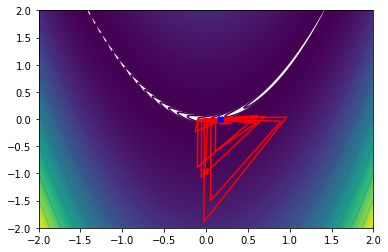

In [42]:
#Here is the contour graph of the function
nx = np.linspace(-2, 2, 400)
ny = np.linspace(-2, 2, 400)

#This is the meshgrid
xm, ym = np.meshgrid(nx, ny)
zm = f([xm, ym])

#This will set the plot
fig = plt.figure()
levels = np.arange(np.min(zm), np.max(zm), 0.3)
plt.contour(xm, ym, zm, levels=levels)
plt.contour(xm, ym, zm)

#This will grab the points from the history
x0 = []
y0 = []
for i in h:
    x0.append(i[0])
    y0.append(i[1])
    
#This is the plot
plt.plot(x0, y0, "r-")
plt.plot(h[0][0], h[0][1], "rX")
plt.plot(h[-1][0], h[-1][1], "bX")

plt.show()

# References

Here are some links about each optimization method

#### Quasi Newton
https://optimization.mccormick.northwestern.edu/index.php/Quasi-Newton_methods

#### Conjugate Descent Method
https://en.wikipedia.org/wiki/Conjugate_gradient_method

https://www.youtube.com/watch?v=h4cG8jLGmKg&t=275s

https://www.youtube.com/watch?v=eAYohMUpPMA

#### Hessian Calculation
https://www.algebrapracticeproblems.com/hessian-matrix/